# Datset: Trackster neighborhood approach

Get tracksters from the cone neighbourhood.

Neighbourhood:
- get links from ticlNtuplizer/graph
    - linked_inners: nodes linked to the given tracksters within its cone

Use the features from MLP approach per trackster.
Look at the graph of tracksters, extract information from the neighborhood and perform link prediction.
- convert the tracksters into some latent space and predict a link between them
- use edgeconv or sageconf to add information from the neighbourhood


In [11]:
import uproot
import torch
import random
import numpy as np

from reco.distance import euclidian_distance
from reco.matching import find_good_pairs
from reco.dataset import match_trackster_pairs, TracksterPairs
from reco.plotting import plot_tracksters
from reco.event import get_bary

import matplotlib.pyplot as plt

# data_root = "/mnt/ceph/users/ecuba/processed"
# raw_dir = "/mnt/ceph/users/ecuba/multiparticle_10/"

data_root = "data"
ds_name = "CloseByTwoPion"
raw_dir = f"/Users/ecuba/data/{ds_name}"
file_name = f"{raw_dir}/new_ntuples_15101852_191.root"

tracksters = uproot.open({file_name: "ticlNtuplizer/tracksters"})
simtracksters = uproot.open({file_name: "ticlNtuplizer/simtrackstersSC"})
associations = uproot.open({file_name: "ticlNtuplizer/associations"})
graph = uproot.open({file_name: "ticlNtuplizer/graph"})

Tracksters: 44
Simtracksters: 2
Candidate pairs: 238


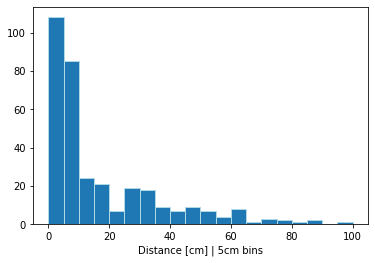

In [23]:
eid = 3

# prepare distance points
vx = tracksters["vertices_x"].array()[eid]
vy = tracksters["vertices_y"].array()[eid]
vz = tracksters["vertices_z"].array()[eid]
ve = tracksters["vertices_energy"].array()[eid]
clouds = [np.array([vx[tid], vy[tid], vz[tid]]).T for tid in range(len(vx))]

print("Tracksters:", len(vx))
print("Simtracksters:", len(simtracksters["stsSC_vertices_x"].array()[eid]))

MAX_DISTANCE = 20   # cm

candidate_pairs = []
distances = []

inners_list = graph["linked_inners"].array()[eid]
for i, inners in enumerate(inners_list):
    for inner in inners:
        dst = euclidian_distance(clouds[i], clouds[inner])
        distances.append(dst)
        if dst <= MAX_DISTANCE:
            candidate_pairs.append((i, inner))
            
print("Candidate pairs:", len(candidate_pairs))

plt.hist(distances, bins=20, edgecolor="lightblue", range=(0, 100))
plt.xlabel("Distance [cm] | 5cm bins")
plt.show()

In [24]:
gt_pairs = match_trackster_pairs(
    tracksters,
    simtracksters,
    associations,
    eid,
    distance_threshold=MAX_DISTANCE,
    best_only=False,
)
print("Ground truth pairs:", len(gt_pairs))

ab_pairs = set([(a, b) for a, b, _ in gt_pairs])
ba_pairs = set([(b, a) for a, b, _ in gt_pairs])
c_pairs = set(candidate_pairs)

positive = ab_pairs.union(ba_pairs).intersection(c_pairs)
negative = c_pairs - positive

Ground truth pairs: 97


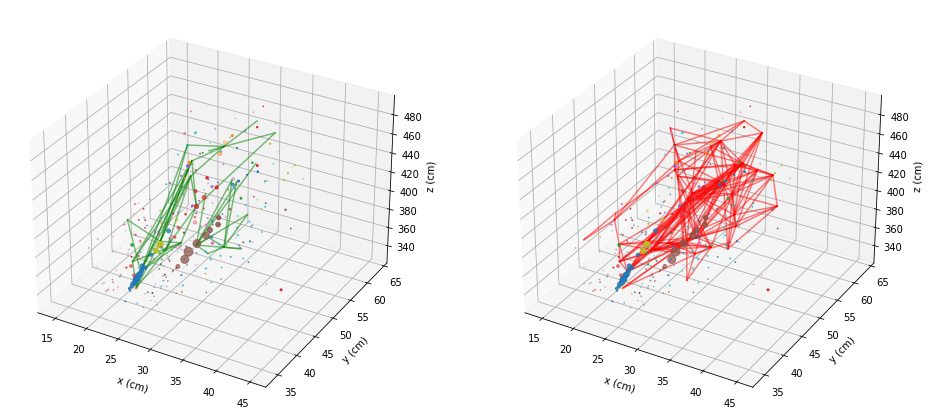

In [25]:
fig = plt.figure(figsize=(16, 8))
ax1 = fig.add_subplot(121, projection='3d')
ax2 = fig.add_subplot(122, projection='3d')
plot_tracksters(ax1, vx, vy, vz, ve)
plot_tracksters(ax2, vx, vy, vz, ve)
bary = get_bary(tracksters, eid)

def plot_edge(ax, edge, color):
    a, b = edge
    ca = bary[a]
    cb = bary[b]
    x = (ca[0], cb[0])
    y = (ca[1], cb[1])
    z = (ca[2], cb[2])
    ax.plot(x, y, z, c=color, alpha=0.5)

for edge in positive:
    plot_edge(ax1, edge, "green")

for edge in negative:
    plot_edge(ax2, edge, "red")

plt.show()